In [2]:
!pip install yfinance pandas matplotlib statsmodels


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

[*********************100%***********************]  1 of 1 completed

Number of rows after removing outliers (Z-score method): 1426


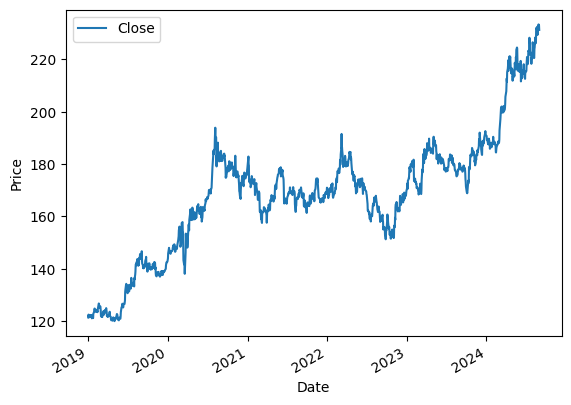

In [28]:
# Define the ticker symbol
ticker = 'GLD'

# Download historical data from Yahoo Finance
data = yf.download(ticker, start='2019-01-01', end='2024-9-01', interval='1d', auto_adjust=True)

missing_values = data['Close'].isna().sum()

# Print if any missing values are found
if missing_values > 0:
    print(f"There are {missing_values} missing values in the 'Close' column.")

# Creates a Z score column and calculates Z-scores per entry
data['Z_score'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()

# Filter out the outliers (Z-scores between -3 and 3)
data_no_outliers_zscore = data[(data['Z_score'] >= -3) & (data['Z_score'] <= 3)]

# Drop the 'Z_score' column if you no longer need it
data_no_outliers_zscore = data_no_outliers_zscore.drop(columns=['Z_score'])

# Keep only the 'Close' price
data = data[['Close']]

# Turn data into a dataframe
df = pd.DataFrame(data)

# Graph the data frame
df.plot(xlabel="Date", ylabel="Price")

#Save data to a csv file
data.to_csv('GLD-Prices.csv', index=True)  # index=True will save the DataFrame index
